In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import time
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('dataset.csv')

In [22]:
# ---Tải và Chuẩn bị dữ liệu ---
df = pd.read_csv('dataset.csv')

# --- Xử lý cột 'Date' ---
# Chuyển đổi, sắp xếp và đặt làm chỉ mục (index)
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date').set_index('Date')
    print("Đã xử lý và sắp xếp dữ liệu theo 'Date'.")

# --- Mục tiêu (y) ---
target_col = 'Revenue_(USD)'
y = df[target_col]

# --- Định nghĩa X (features) là các cột số còn lại ---
numeric_features = df.select_dtypes(include=np.number).columns
X_cols = numeric_features.drop(target_col, errors='ignore')
X = df[X_cols]

print(f"Số lượng mẫu cuối cùng để huấn luyện: {len(X)}")



Đã xử lý và sắp xếp dữ liệu theo 'Date'.
Số lượng mẫu cuối cùng để huấn luyện: 1132


# (a) Thiết lập các hàm

#### Hàm vòng lặp Huấn luyện mô hình K-NN và Đánh giá

In [23]:
def my_knn(X_data_raw, y, datasets, splits, israndom=True, log_transform=False):
    """
    Huấn luyện mô hình KNN Regressor (Split-then-Scale).
    (SỬA LỖI: Lưu trữ X_train/X_test dưới dạng DataFrame CÓ INDEX)
    """
    results = []
    model_records = []

    for data_name, X_dataset_raw in datasets.items():
        for split_name, test_size in splits.items():

            # --- 1. Chia dữ liệu ---
            if israndom:
                X_train_raw, X_test_raw, y_train, y_test = train_test_split(
                    X_dataset_raw, y, test_size=test_size, random_state=42
                )
            else:
                n_train = int((1 - test_size) * len(X_dataset_raw))
                X_train_raw, X_test_raw = X_dataset_raw.iloc[:n_train], X_dataset_raw.iloc[n_train:]
                y_train, y_test = y.iloc[:n_train], y.iloc[n_train:]

            if X_test_raw.empty or y_test.empty:
                print(f"Bỏ qua {data_name} / {split_name} (chia tuần tự) vì tập test rỗng.")
                continue

            # --- 2. Chuẩn hóa (SAU KHI CHIA) ---
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_raw)
            X_test_scaled = scaler.transform(X_test_raw)

            # --- 3. Xử lý PCA (Nếu cần, dựa trên tên) ---
            X_train = X_train_scaled
            X_test = X_test_scaled
            feature_columns = X_train_raw.columns

            if "PCA" in data_name:
                pca = PCA(n_components=0.95)
                X_train = pca.fit_transform(X_train_scaled)
                X_test = pca.transform(X_test_scaled)
                feature_columns = [f"Feature_{i+1}" for i in range(X_train.shape[1])]

            # --- 4. Huấn luyện mô hình ---
            model = KNeighborsRegressor()
            model.fit(X_train, y_train)

            # --- 5. Dự đoán ---
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            # --- 6. Chuyển đổi Log (nếu cần) ---
            if log_transform:
                y_train_pred[y_train_pred < 0] = 0
                y_test_pred[y_test_pred < 0] = 0
                y_train_pred_orig = np.expm1(y_train_pred)
                y_test_pred_orig = np.expm1(y_test_pred)
                y_train_orig = np.expm1(y_train)
                y_test_orig = np.expm1(y_test)
            else:
                y_train_pred_orig, y_test_pred_orig = y_train_pred, y_test_pred
                y_train_orig, y_test_orig = y_train, y_test

            # --- 7. Tính toán chỉ số ---
            train_r2 = r2_score(y_train_orig, y_train_pred_orig)
            test_r2 = r2_score(y_test_orig, y_test_pred_orig)
            train_rmse = np.sqrt(mean_squared_error(y_train_orig, y_train_pred_orig))
            test_rmse = np.sqrt(mean_squared_error(y_test_orig, y_test_pred_orig))

            # --- 8. Lưu kết quả đánh giá ---
            results.append({
                "Loại dữ liệu": data_name,
                "Tỷ lệ (Train:Val)": split_name,
                "Train R2": train_r2,
                "Test R2": test_r2,
                "Train RMSE (USD)": train_rmse,
                "Test RMSE (USD)": test_rmse
            })

            # --- 9. (SỬA LỖI INDEX) Lưu lại model và DataFrame (giữ index) ---
            model_records.append({
                "dataset": data_name,
                "split": split_name,
                "model": model,
                "X_train": pd.DataFrame(X_train, columns=feature_columns, index=y_train.index),
                "y_train": y_train,
                "X_test": pd.DataFrame(X_test, columns=feature_columns, index=y_test.index),
                "y_test": y_test,
                "log_transform": log_transform
            })

    return results, model_records

#### Hàm trực quan hóa kết quả đánh giá mô hình

In [24]:
def show_knn_results(results):
    # Chuyển sang DataFrame
    results_df = pd.DataFrame(results)

    # Làm tròn số
    results_df["Train R2"] = results_df["Train R2"].round(3)
    results_df["Test R2"] = results_df["Test R2"].round(3)
    results_df["Train RMSE (USD)"] = results_df["Train RMSE (USD)"].round(2)
    results_df["Test RMSE (USD)"] = results_df["Test RMSE (USD)"].round(2)

    print("\n📊 Kết quả tổng hợp KNN:")
    display(results_df.style.background_gradient(
        subset=["Train R2", "Test R2"], cmap="YlGn").background_gradient(
        subset=["Train RMSE (USD)", "Test RMSE (USD)"], cmap="YlOrRd_r"))

    # ---- BIỂU ĐỒ SO SÁNH ----
    plt.figure(figsize=(10, 6))

    for data_name in results_df["Loại dữ liệu"].unique():
        subset = results_df[results_df["Loại dữ liệu"] == data_name]

        # Đường Test R²
        plt.plot(
            subset["Tỷ lệ (Train:Val)"],
            subset["Test R2"],
            marker="o",
            label=f"{data_name} - Test R²",
            linestyle="-"
        )

        # Đường Train R²
        plt.plot(
            subset["Tỷ lệ (Train:Val)"],
            subset["Train R2"],
            marker="s",
            label=f"{data_name} - Train R²",
            linestyle="--"
        )

    plt.title("So sánh R² giữa các loại dữ liệu và tỷ lệ Train/Test")
    plt.xlabel("Tỷ lệ (Train:Val)")
    plt.ylabel("R²")
    plt.legend()
    plt.grid(True)
    plt.show()


#### Hàm trực quan hóa và đánh giá tương quan giữa phần dư (Residuals) và đầu vào.

In [25]:
from IPython.display import display

def analyze_residuals(model_records, data_name=None, split_name=None):
    """
    Phân tích phần dư (residuals) để ĐÁNH GIÁ TÍNH PHÙ HỢP CỦA MÔ HÌNH.
    """
    print("\n--- BẮT ĐẦU PHÂN TÍCH PHẦN DƯ ---")

    for rec in model_records:
        ds_name = rec["dataset"]
        sp_name = rec["split"]

        if data_name is not None and ds_name != data_name:
            continue
        if split_name is not None and sp_name != split_name:
            continue

        model = rec["model"]
        X_train, y_train = rec["X_train"], rec["y_train"]
        X_test, y_test = rec["X_test"], rec["y_test"]
        log_transform = rec.get("log_transform", False)

        y_train_pred = model.predict(X_train.values)
        y_test_pred = model.predict(X_test.values)

        if log_transform:
            y_train_orig = np.expm1(y_train)
            y_test_orig = np.expm1(y_test)
            y_train_pred_orig = np.expm1(y_train_pred)
            y_test_pred_orig = np.expm1(y_test_pred)
        else:
            y_train_orig = y_train
            y_test_orig = y_test
            y_train_pred_orig = y_train_pred
            y_test_pred_orig = y_test_pred

        y_train_pred_s = pd.Series(y_train_pred_orig, index=y_train.index)
        y_test_pred_s = pd.Series(y_test_pred_orig, index=y_test.index)

        train_residuals = y_train_orig - y_train_pred_s
        test_residuals = y_test_orig - y_test_pred_s

        nan_mask_train = ~np.isnan(train_residuals)
        X_train_f = X_train[nan_mask_train]
        train_residuals_f = train_residuals[nan_mask_train]

        nan_mask_test = ~np.isnan(test_residuals)
        X_test_f = X_test[nan_mask_test]
        y_test_pred_f = y_test_pred_s[nan_mask_test]
        test_residuals_f = test_residuals[nan_mask_test]

        print(f"\n🔍 Phân tích đánh giá mô hình cho: {ds_name} ({sp_name})")
        print("=" * 80)

        # --- 1. Biểu đồ Hộp phân bố phần dư---

        # Chuẩn bị dữ liệu cho biểu đồ hộp
        train_res_df = pd.DataFrame({'Residuals': train_residuals_f, 'Type': 'Train'})
        test_res_df = pd.DataFrame({'Residuals': test_residuals_f, 'Type': 'Test'})
        combined_res_df = pd.concat([train_res_df, test_res_df])

        plt.figure(figsize=(8, 6))
        sns.boxplot(data=combined_res_df, x='Type', y='Residuals')
        plt.title(f"Biểu đồ Hộp Phân bố Phần dư - {ds_name} ({sp_name})")
        plt.axhline(0, color='red', linestyle='--')
        plt.ylabel("Residuals (USD)")
        plt.xlabel("Tập dữ liệu")
        plt.show()

        # --- 2. Biểu đồ Phần dư vs. Dự đoán (Tập TEST) ---
        plt.figure(figsize=(7, 5))
        sns.scatterplot(x=y_test_pred_f, y=test_residuals_f, alpha=0.6, color='green')
        plt.axhline(0, color='red', linestyle='--')
        plt.title(f"Residuals vs Predicted (TẬP TEST) - {ds_name} ({sp_name})")
        plt.xlabel("Predicted Values (USD)")
        plt.ylabel("Residuals (USD)")
        plt.tight_layout()
        plt.show()

        # --- 3. Bảng tương quan Phần dư (TEST) và Biến đầu vào ---
        residual_corrs_test = {}
        for col in X_test_f.columns:
            valid_X = X_test_f[col]
            valid_y = test_residuals_f

            if len(valid_X) > 1 and np.var(valid_X) > 0:
                corr = np.corrcoef(valid_X, valid_y)[0, 1]
                residual_corrs_test[col] = corr
            else:
                residual_corrs_test[col] = np.nan

        corr_df_test = pd.DataFrame(list(residual_corrs_test.items()),
                               columns=['Biến đầu vào', 'Hệ số tương quan với phần dư (Test)'])
        corr_df_test['|Tuyệt đối|'] = np.abs(corr_df_test['Hệ số tương quan với phần dư (Test)'])
        corr_df_test = corr_df_test.sort_values(by='|Tuyệt đối|', ascending=False)

        print("\n📊 Hệ số tương quan giữa phần dư (TẬP TEST) và các biến đầu vào:")
        print("   (Mô hình TỐT nếu các hệ số này GẦN 0)")
        print(corr_df_test.to_string(index=False))

        # --- 4. Trực quan hóa Top 3 tương quan mạnh nhất (TẬP TEST) ---
        top_vars_test = corr_df_test.dropna().head(3)['Biến đầu vào']


        plt.figure(figsize=(15, 4))
        plt.suptitle(f"Top 3 Tương quan Phần dư (TẬP TEST) - {ds_name} ({sp_name})", fontweight='bold')
        for i, var in enumerate(top_vars_test):
            plt.subplot(1, 3, i + 1)
            sns.scatterplot(x=X_test_f[var], y=test_residuals_f, alpha=0.6, color='green')
            plt.axhline(y=0, color='red', linestyle='--')
            plt.title(f"Residuals (Test) vs {var}")
            plt.ylabel("Residuals (USD)")

        plt.tight_layout()
        plt.show()



# (b) Dữ liệu không biến đổi logarit

## Thiết lập Thử nghiệm với dữ liệu gốc

In [26]:
# Định nghĩa các bộ dữ liệu sẽ chạy
# Chúng ta sẽ truyền dữ liệu X thô, và kiểm tra tên (data_name) trong hàm my_knn
datasets = {
    "Dữ liệu gốc": X,
    "Dữ liệu giảm chiều (PCA-95%)": X
}

# Định nghĩa các tỷ lệ chia
splits = {
    "4:1 (test=20%)": 0.2,
    "7:3 (test=30%)": 0.3,
    "6:4 (test=40%)": 0.4
}

## (b.1) Chạy mô hình và đánh giá với cách chia tập dữ liệu train-test ngẫu nhiên


📊 Kết quả tổng hợp KNN:


,Loại dữ liệu,Tỷ lệ (Train:Val),Train R2,Test R2,Train RMSE (USD),Test RMSE (USD)
0,Dữ liệu gốc,4:1 (test=20%),0.979000,0.983000,6.830000,5.660000
1,Dữ liệu gốc,7:3 (test=30%),0.976000,0.979000,7.370000,6.550000
2,Dữ liệu gốc,6:4 (test=40%),0.977000,0.978000,6.870000,7.180000
3,Dữ liệu giảm chiều (PCA-95%),4:1 (test=20%),0.978000,0.978000,7.100000,6.330000
4,Dữ liệu giảm chiều (PCA-95%),7:3 (test=30%),0.975000,0.980000,7.400000,6.530000
5,Dữ liệu giảm chiều (PCA-95%),6:4 (test=40%),0.978000,0.976000,6.800000,7.530000


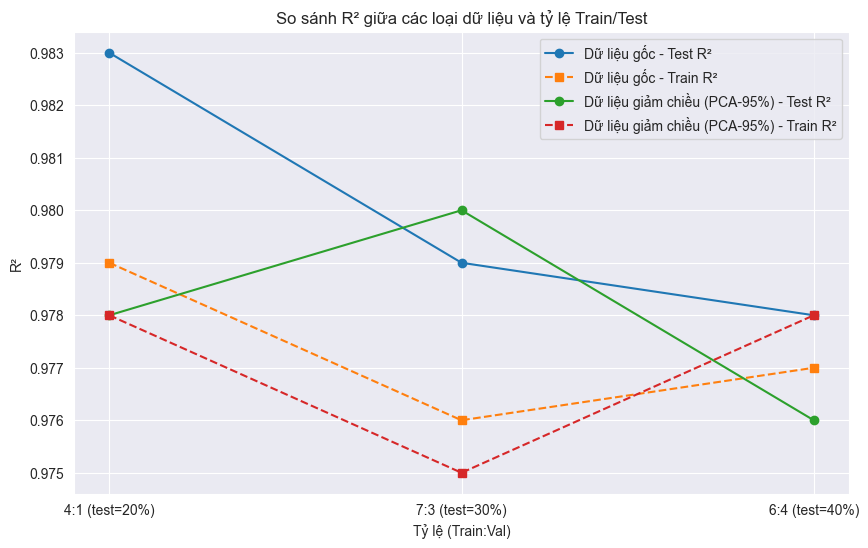

In [27]:
results, model_records_random = my_knn(X, y, datasets, splits, israndom = True)
show_knn_results(results)

#### Trực quan hóa và đánh giá tương quan giữa phần dư (sai lệch dự đoán – thực tế) và bản thân đầu vào.


--- BẮT ĐẦU PHÂN TÍCH PHẦN DƯ ---

🔍 Phân tích đánh giá mô hình cho: Dữ liệu gốc (4:1 (test=20%))


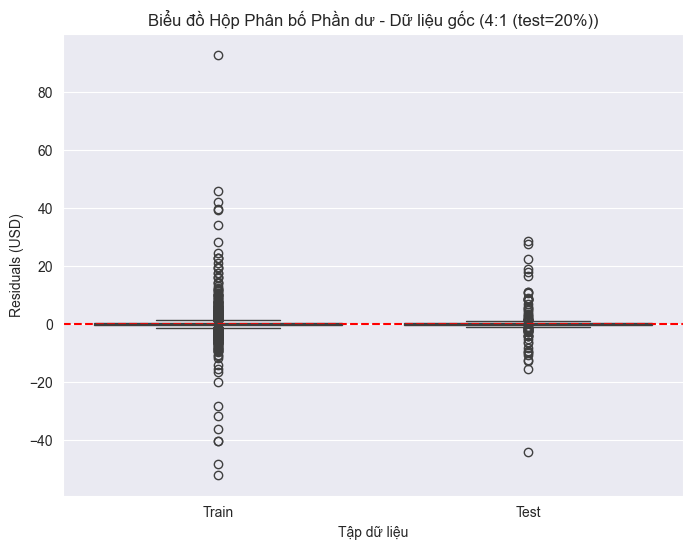

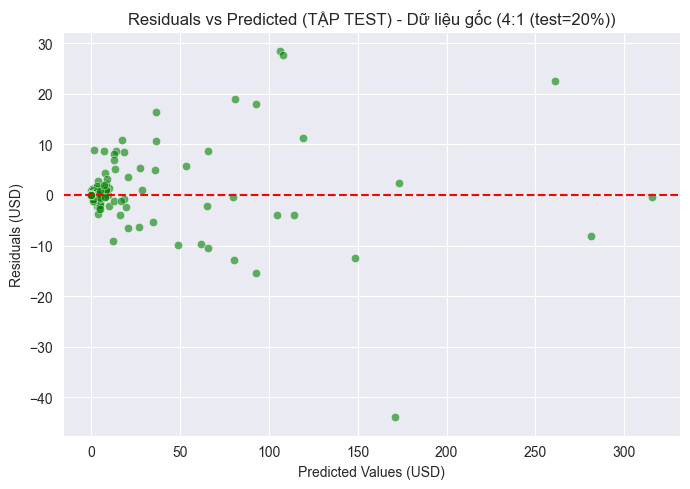


📊 Hệ số tương quan giữa phần dư (TẬP TEST) và các biến đầu vào:
   (Mô hình TỐT nếu các hệ số này GẦN 0)
            Biến đầu vào  Hệ số tương quan với phần dư (Test)  |Tuyệt đối|
        Subs_accumulated                             0.282348     0.282348
                  Shares                             0.224048     0.224048
          Unique_viewers                             0.116644     0.116644
                Dislikes                             0.110157     0.110157
             Impressions                             0.097989     0.097989
                   Views                             0.093992     0.093992
                   Likes                             0.072693     0.072693
          Click_rate_(%)                            -0.056787     0.056787
      Average_viewed_(%)                             0.049635     0.049635
        Videos_published                            -0.041876     0.041876
             Watch_hours                             0.038717     0.0

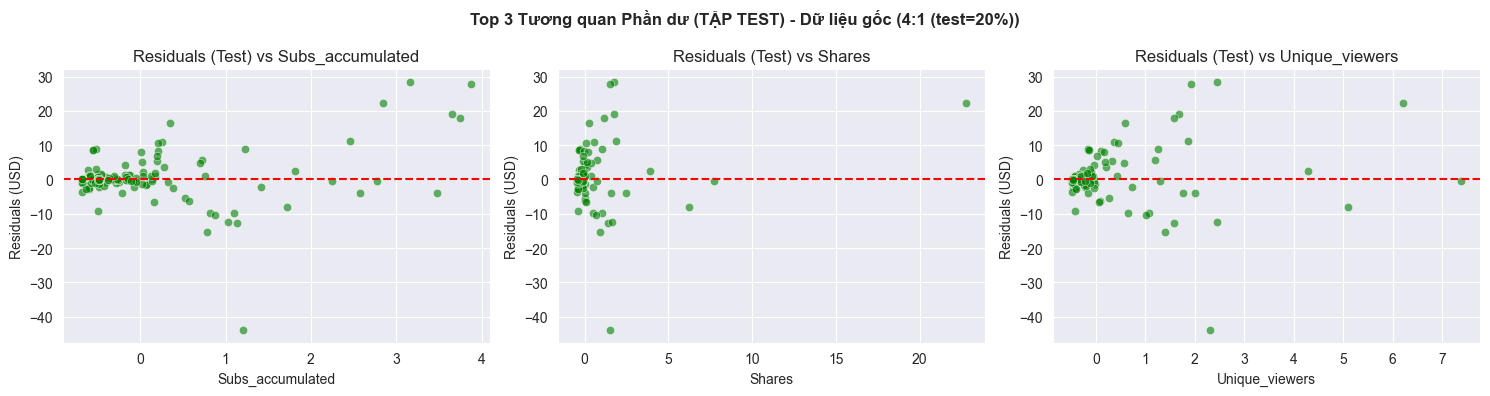

In [28]:
data_name = "Dữ liệu gốc"
split_name = "4:1 (test=20%)"
analyze_residuals(model_records_random, data_name, split_name)



--- BẮT ĐẦU PHÂN TÍCH PHẦN DƯ ---

🔍 Phân tích đánh giá mô hình cho: Dữ liệu giảm chiều (PCA-95%) (4:1 (test=20%))


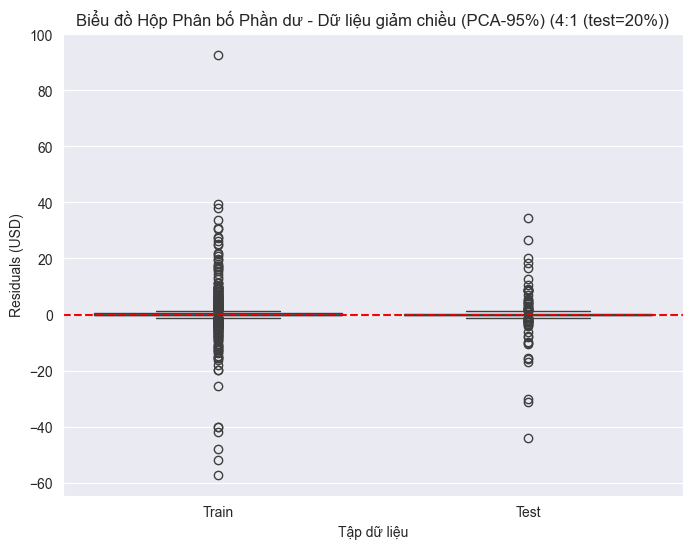

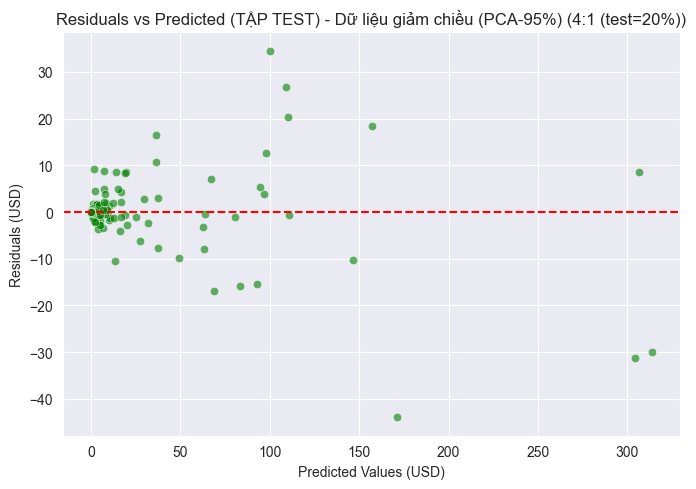


📊 Hệ số tương quan giữa phần dư (TẬP TEST) và các biến đầu vào:
   (Mô hình TỐT nếu các hệ số này GẦN 0)
Biến đầu vào  Hệ số tương quan với phần dư (Test)  |Tuyệt đối|
   Feature_5                             0.244163     0.244163
   Feature_2                            -0.234248     0.234248
   Feature_1                            -0.166824     0.166824
   Feature_6                            -0.144207     0.144207
   Feature_4                            -0.010275     0.010275
   Feature_3                            -0.003777     0.003777


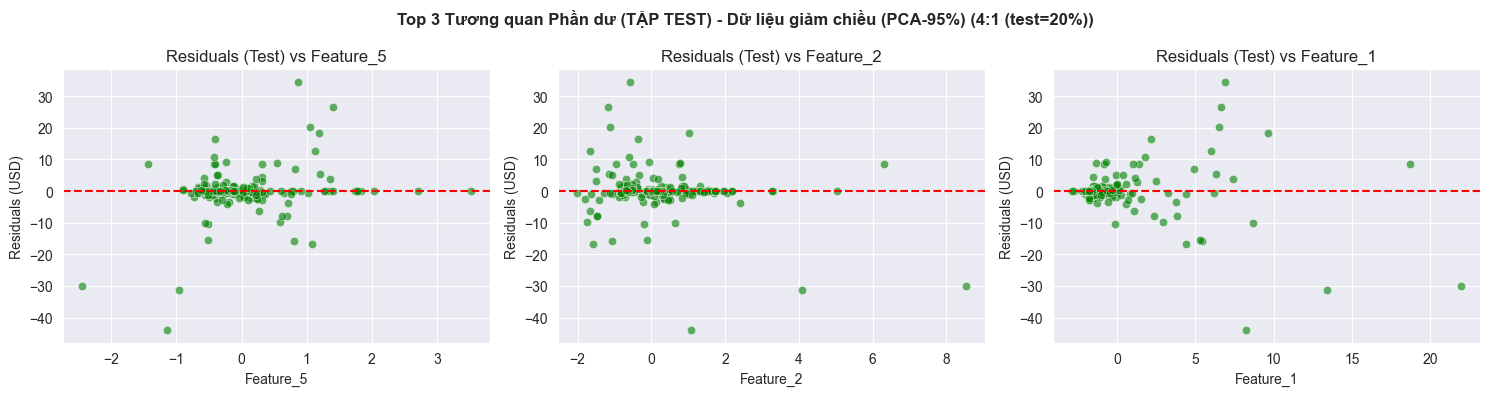

In [29]:
data_name = "Dữ liệu giảm chiều (PCA-95%)"
split_name = "4:1 (test=20%)"
analyze_residuals(model_records_random, data_name, split_name)

## (b.2) Chạy mô hình và đánh giá với cách chia tập dữ liệu train-test tuần tự


📊 Kết quả tổng hợp KNN:


,Loại dữ liệu,Tỷ lệ (Train:Val),Train R2,Test R2,Train RMSE (USD),Test RMSE (USD)
0,Dữ liệu gốc,4:1 (test=20%),0.917000,-0.734000,1.190000,93.650000
1,Dữ liệu gốc,7:3 (test=30%),0.895000,-0.332000,1.110000,79.850000
2,Dữ liệu gốc,6:4 (test=40%),0.865000,-0.198000,1.180000,71.120000
3,Dữ liệu giảm chiều (PCA-95%),4:1 (test=20%),0.921000,-0.732000,1.160000,93.620000
4,Dữ liệu giảm chiều (PCA-95%),7:3 (test=30%),0.885000,-0.332000,1.160000,79.850000
5,Dữ liệu giảm chiều (PCA-95%),6:4 (test=40%),0.847000,-0.249000,1.260000,72.630000


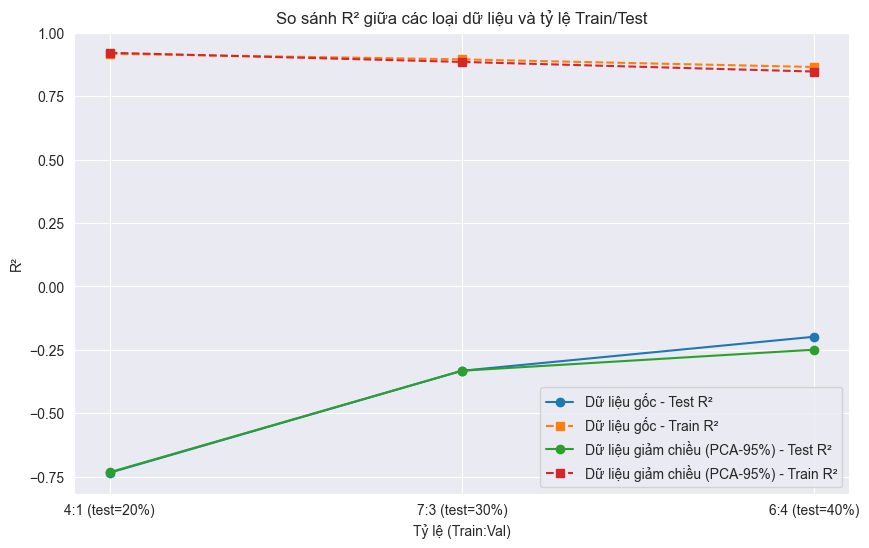

In [30]:
results, model_records = my_knn(X, y, datasets, splits, israndom = False)
show_knn_results(results)

#### Trực quan hóa và đánh giá tương quan giữa phần dư (sai lệch dự đoán – thực tế) và bản thân đầu vào.


--- BẮT ĐẦU PHÂN TÍCH PHẦN DƯ ---

🔍 Phân tích đánh giá mô hình cho: Dữ liệu gốc (4:1 (test=20%))


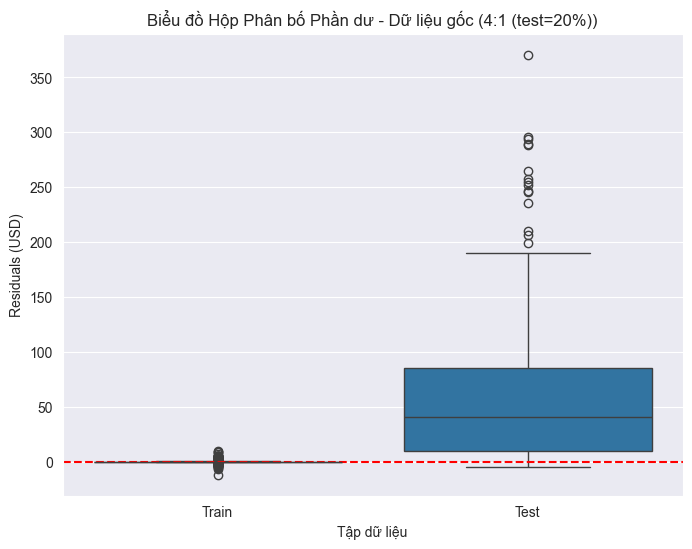

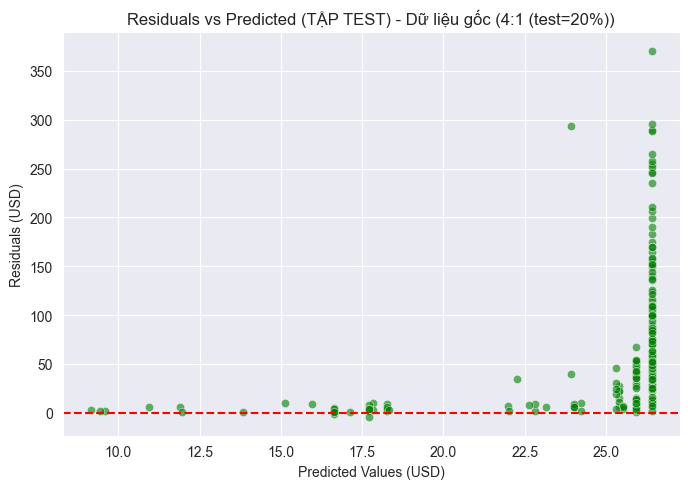


📊 Hệ số tương quan giữa phần dư (TẬP TEST) và các biến đầu vào:
   (Mô hình TỐT nếu các hệ số này GẦN 0)
            Biến đầu vào  Hệ số tương quan với phần dư (Test)  |Tuyệt đối|
             Watch_hours                             0.964803     0.964803
          Unique_viewers                             0.954976     0.954976
                   Likes                             0.947154     0.947154
                   Views                             0.947092     0.947092
                Dislikes                             0.924658     0.924658
             Impressions                             0.864685     0.864685
                Comments                             0.799495     0.799495
                  Shares                             0.693407     0.693407
        Subs_accumulated                             0.622163     0.622163
      Average_viewed_(%)                             0.546777     0.546777
        Average_view_sec                             0.453172     0.4

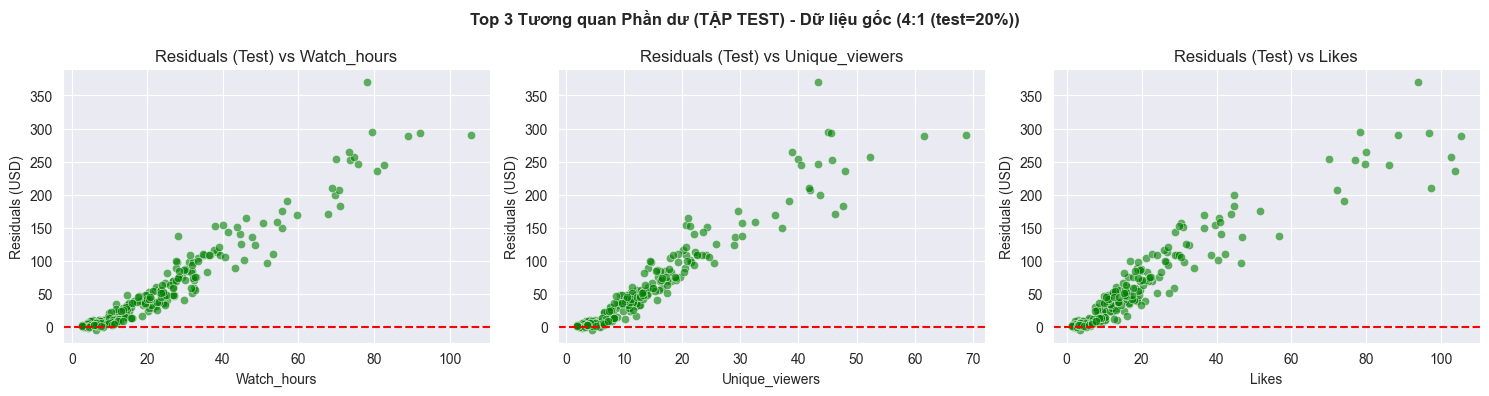

In [31]:
data_name = "Dữ liệu gốc"
split_name = "4:1 (test=20%)"
analyze_residuals(model_records, data_name, split_name)


--- BẮT ĐẦU PHÂN TÍCH PHẦN DƯ ---

🔍 Phân tích đánh giá mô hình cho: Dữ liệu giảm chiều (PCA-95%) (4:1 (test=20%))


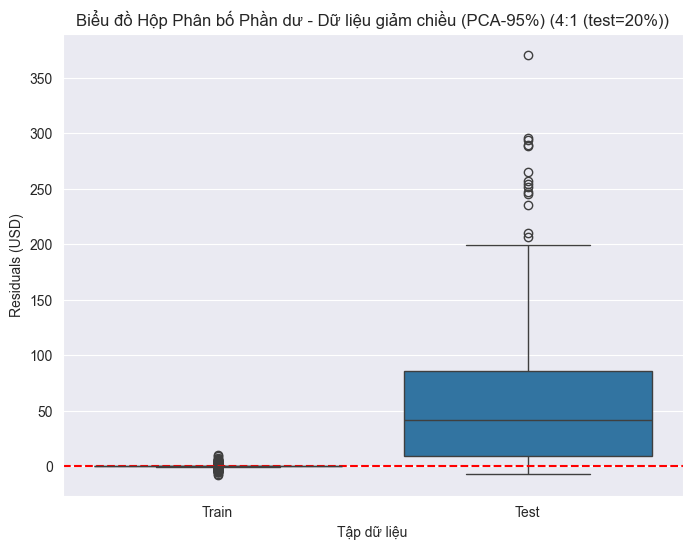

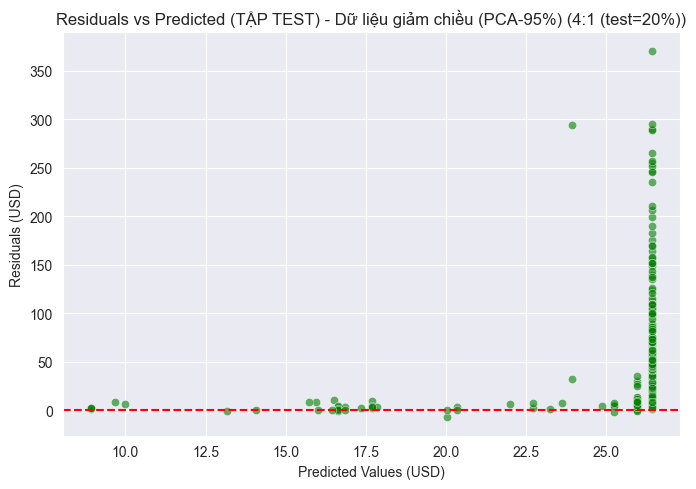


📊 Hệ số tương quan giữa phần dư (TẬP TEST) và các biến đầu vào:
   (Mô hình TỐT nếu các hệ số này GẦN 0)
Biến đầu vào  Hệ số tương quan với phần dư (Test)  |Tuyệt đối|
   Feature_1                             0.958487     0.958487
   Feature_5                            -0.953852     0.953852
   Feature_4                            -0.918737     0.918737
   Feature_2                            -0.882638     0.882638
   Feature_7                             0.436262     0.436262
   Feature_6                             0.415316     0.415316
   Feature_3                             0.364685     0.364685


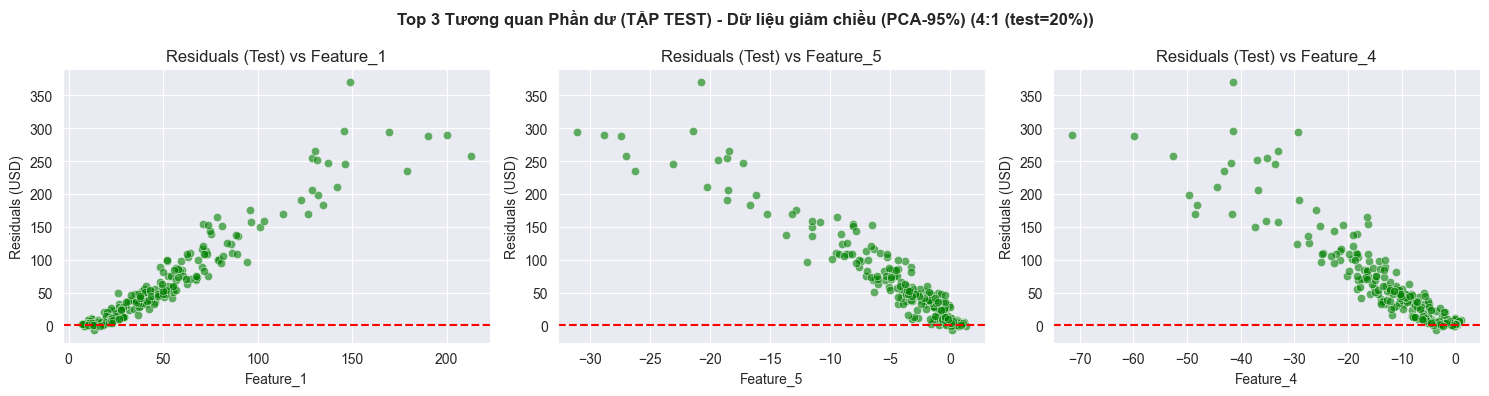

In [32]:
data_name = "Dữ liệu giảm chiều (PCA-95%)"
split_name = "4:1 (test=20%)"
analyze_residuals(model_records, data_name, split_name)

# (c) Chuẩn bị các bộ dữ liệu 2: Dữ liệu biến đổi logarit

In [33]:
X_log = np.log1p(X)
y_log = np.log1p(y)

## Thiết lập Thử nghiệm với dữ liệu logarit

In [34]:
# Định nghĩa các bộ dữ liệu sẽ chạy
# Chúng ta sẽ truyền dữ liệu X_log, và kiểm tra tên (data_name) trong hàm my_knn
datasets_log = {
    "Dữ liệu biến đổi logarit": X_log,
    "Dữ liệu biến đổi logarit + giảm chiều (PCA-95%)": X_log
}

# Định nghĩa các tỷ lệ chia
splits_log = {
    "4:1 (test=20%)": 0.2,
    "7:3 (test=30%)": 0.3,
    "6:4 (test=40%)": 0.4
}

## (c.1) Chạy mô hình và đánh giá với cách chia tập dữ liệu train-test ngẫu nhiên


📊 Kết quả tổng hợp KNN:


,Loại dữ liệu,Tỷ lệ (Train:Val),Train R2,Test R2,Train RMSE (USD),Test RMSE (USD)
0,Dữ liệu biến đổi logarit,4:1 (test=20%),0.948000,0.928000,10.880000,11.490000
1,Dữ liệu biến đổi logarit,7:3 (test=30%),0.934000,0.930000,12.120000,12.110000
2,Dữ liệu biến đổi logarit,6:4 (test=40%),0.934000,0.903000,11.670000,15.010000
3,Dữ liệu biến đổi logarit + giảm chiều (PCA-95%),4:1 (test=20%),0.945000,0.937000,11.120000,10.790000
4,Dữ liệu biến đổi logarit + giảm chiều (PCA-95%),7:3 (test=30%),0.937000,0.923000,11.870000,12.640000
5,Dữ liệu biến đổi logarit + giảm chiều (PCA-95%),6:4 (test=40%),0.938000,0.905000,11.360000,14.890000


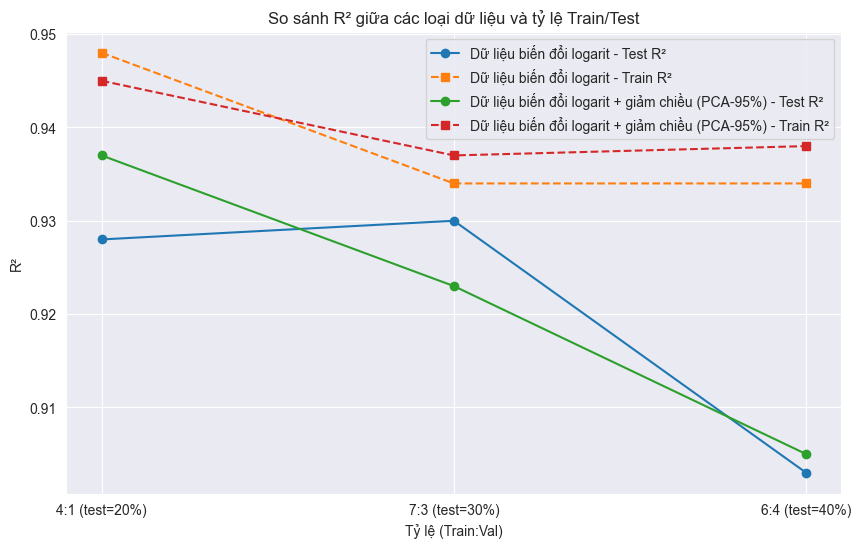

In [35]:
results_log_random, model_log_records_random = my_knn(X_log, y_log, datasets_log, splits_log, israndom = True, log_transform=True)
show_knn_results(results_log_random)

#### Trực quan hóa và đánh giá tương quan giữa phần dư (sai lệch dự đoán – thực tế) và bản thân đầu vào.


--- BẮT ĐẦU PHÂN TÍCH PHẦN DƯ ---

🔍 Phân tích đánh giá mô hình cho: Dữ liệu biến đổi logarit (4:1 (test=20%))


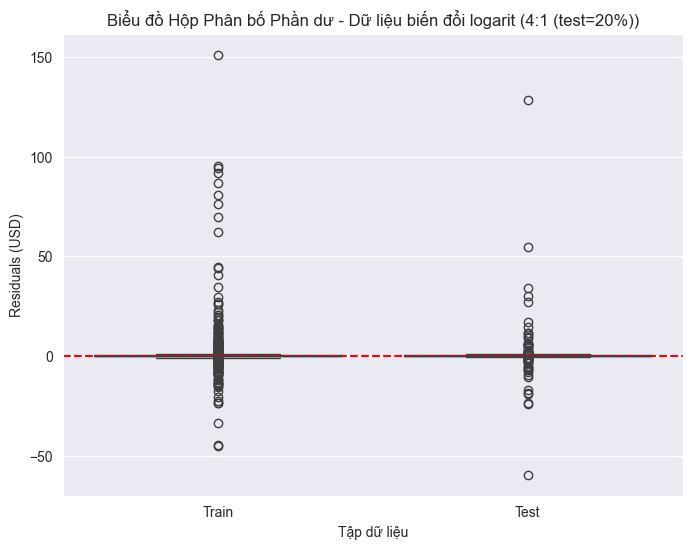

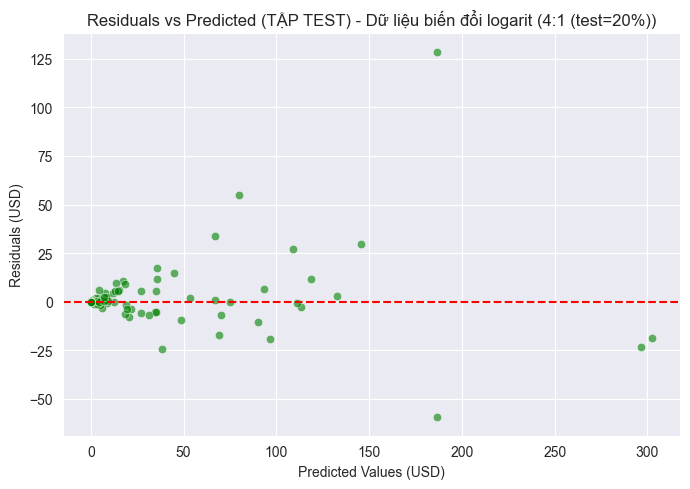


📊 Hệ số tương quan giữa phần dư (TẬP TEST) và các biến đầu vào:
   (Mô hình TỐT nếu các hệ số này GẦN 0)
            Biến đầu vào  Hệ số tương quan với phần dư (Test)  |Tuyệt đối|
                Dislikes                             0.156997     0.156997
                  Shares                             0.147065     0.147065
                Comments                             0.138930     0.138930
          Unique_viewers                             0.138860     0.138860
                   Views                             0.136853     0.136853
                   Likes                             0.136552     0.136552
             Watch_hours                             0.136447     0.136447
             Impressions                             0.135073     0.135073
        Videos_published                             0.127637     0.127637
      Average_viewed_(%)                             0.109041     0.109041
        Subs_accumulated                             0.091658     0.0

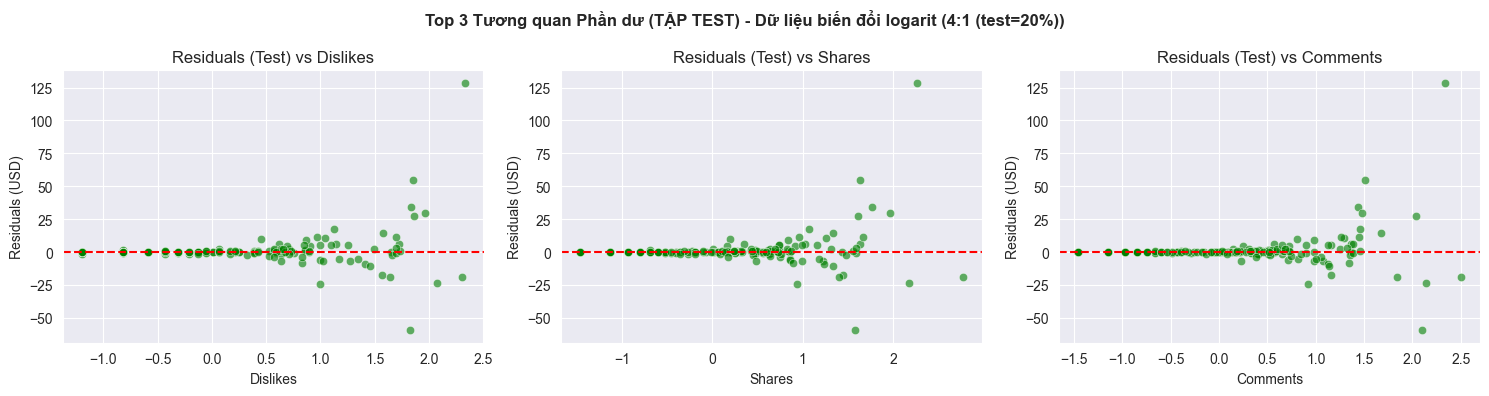

In [36]:
data_name = "Dữ liệu biến đổi logarit"
split_name = "4:1 (test=20%)"
analyze_residuals(model_log_records_random, data_name, split_name)


--- BẮT ĐẦU PHÂN TÍCH PHẦN DƯ ---

🔍 Phân tích đánh giá mô hình cho: Dữ liệu biến đổi logarit + giảm chiều (PCA-95%) (4:1 (test=20%))


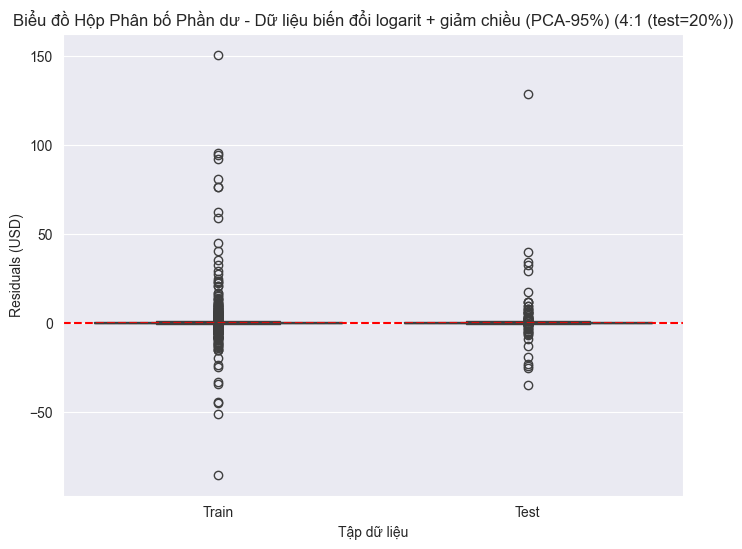

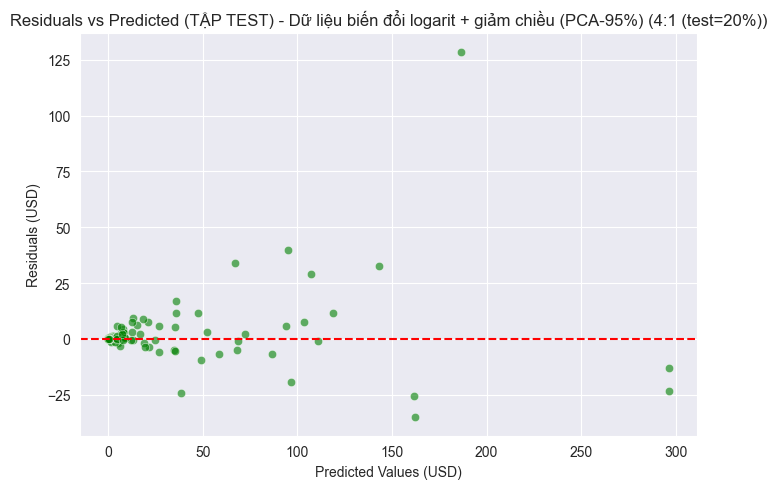


📊 Hệ số tương quan giữa phần dư (TẬP TEST) và các biến đầu vào:
   (Mô hình TỐT nếu các hệ số này GẦN 0)
Biến đầu vào  Hệ số tương quan với phần dư (Test)  |Tuyệt đối|
   Feature_1                             0.165948     0.165948
   Feature_2                             0.097802     0.097802
   Feature_3                             0.071485     0.071485
   Feature_5                            -0.064815     0.064815
   Feature_4                            -0.059581     0.059581


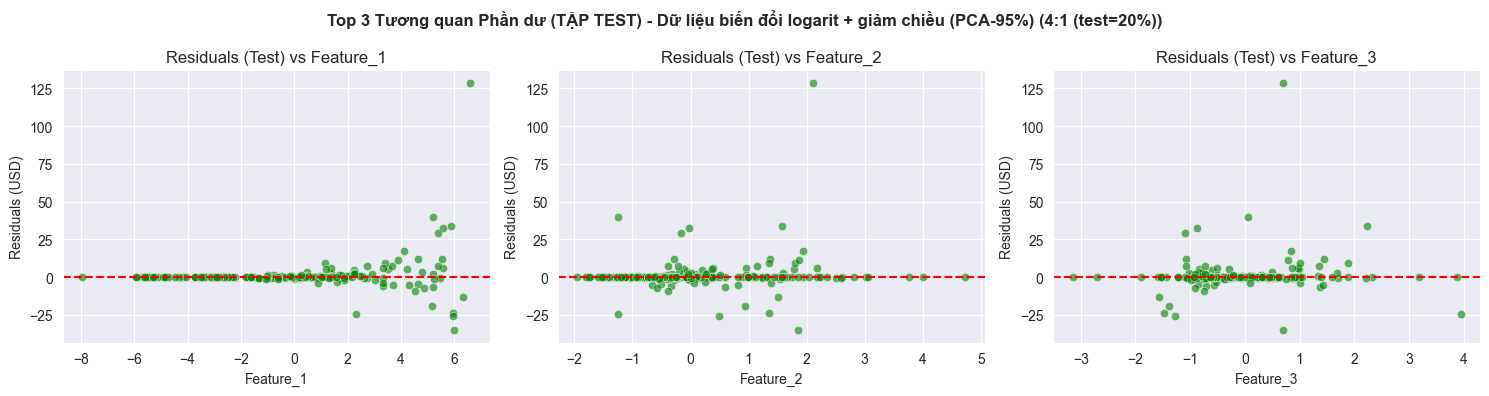

In [37]:
data_name = "Dữ liệu biến đổi logarit + giảm chiều (PCA-95%)"
split_name = "4:1 (test=20%)"
analyze_residuals(model_log_records_random, data_name, split_name)

## (c.2) Chạy mô hình và đánh giá với cách chia tập dữ liệu train-test tuần tự


📊 Kết quả tổng hợp KNN:


,Loại dữ liệu,Tỷ lệ (Train:Val),Train R2,Test R2,Train RMSE (USD),Test RMSE (USD)
0,Dữ liệu biến đổi logarit,4:1 (test=20%),0.910000,-0.948000,1.240000,99.260000
1,Dữ liệu biến đổi logarit,7:3 (test=30%),0.882000,-0.429000,1.180000,82.720000
2,Dữ liệu biến đổi logarit,6:4 (test=40%),0.897000,-0.390000,1.030000,76.600000
3,Dữ liệu biến đổi logarit + giảm chiều (PCA-95%),4:1 (test=20%),0.905000,-0.937000,1.270000,98.980000
4,Dữ liệu biến đổi logarit + giảm chiều (PCA-95%),7:3 (test=30%),0.879000,-0.431000,1.200000,82.770000
5,Dữ liệu biến đổi logarit + giảm chiều (PCA-95%),6:4 (test=40%),0.903000,-0.395000,1.000000,76.740000


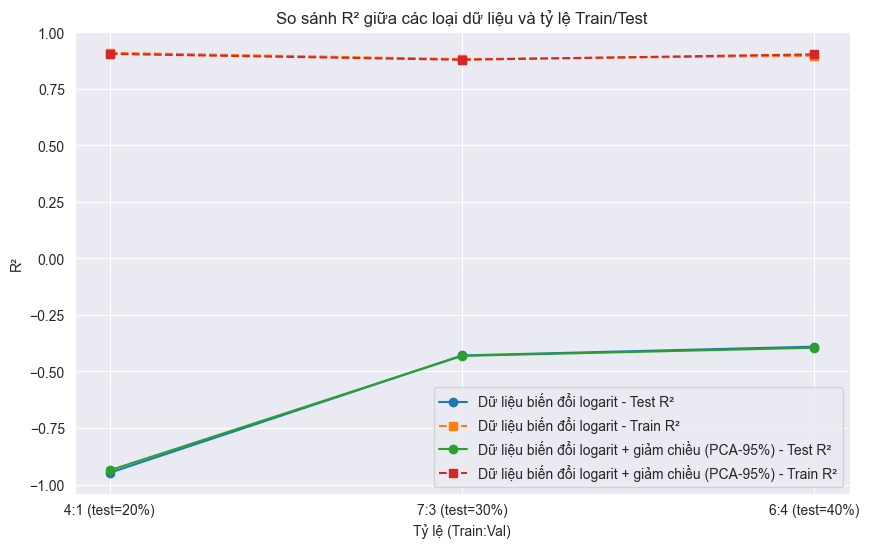

In [38]:
results_log, model_log_records = my_knn(X_log, y_log, datasets_log, splits_log, israndom = False, log_transform=True)
show_knn_results(results_log)

#### Trực quan hóa và đánh giá tương quan giữa phần dư (sai lệch dự đoán – thực tế) và bản thân đầu vào.


--- BẮT ĐẦU PHÂN TÍCH PHẦN DƯ ---

🔍 Phân tích đánh giá mô hình cho: Dữ liệu biến đổi logarit (4:1 (test=20%))


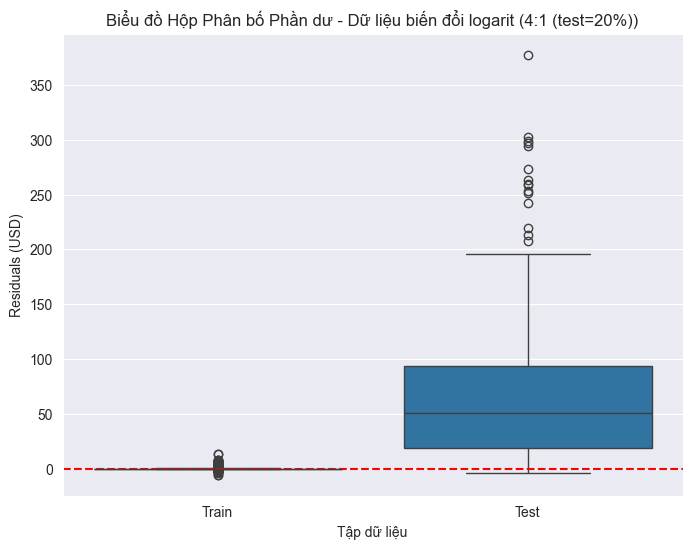

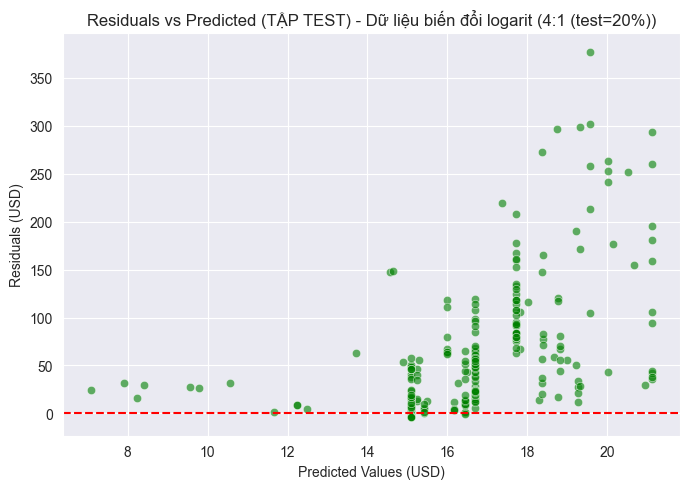


📊 Hệ số tương quan giữa phần dư (TẬP TEST) và các biến đầu vào:
   (Mô hình TỐT nếu các hệ số này GẦN 0)
            Biến đầu vào  Hệ số tương quan với phần dư (Test)  |Tuyệt đối|
          Unique_viewers                             0.893622     0.893622
                   Likes                             0.887690     0.887690
             Watch_hours                             0.863736     0.863736
                   Views                             0.860784     0.860784
                Dislikes                             0.844826     0.844826
                Comments                             0.836368     0.836368
                  Shares                             0.815254     0.815254
             Impressions                             0.796387     0.796387
        Subs_accumulated                             0.665872     0.665872
        Average_view_sec                             0.440763     0.440763
      Average_viewed_(%)                             0.426189     0.4

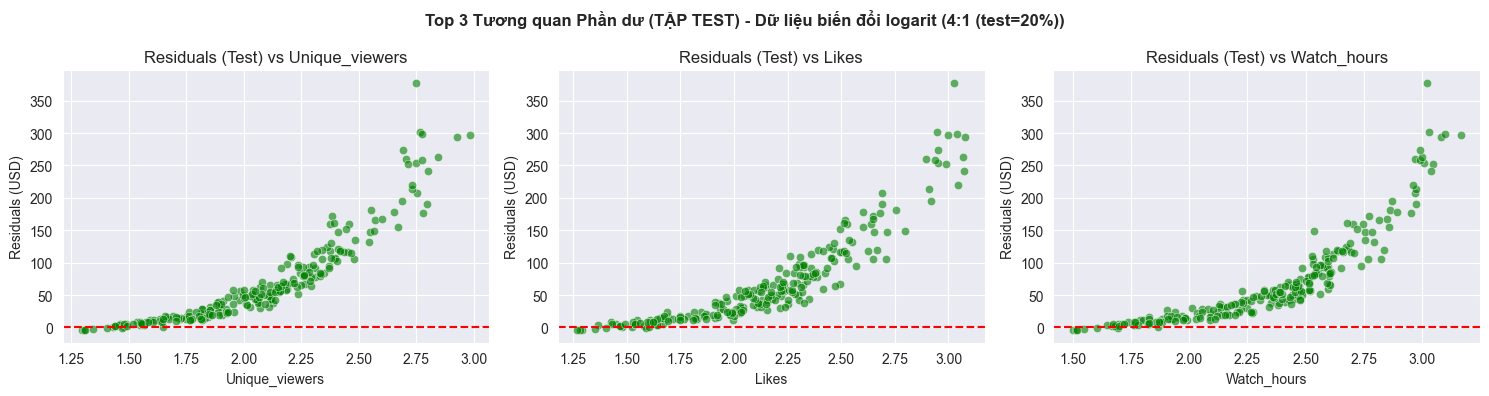

In [39]:
data_name = "Dữ liệu biến đổi logarit"
split_name = "4:1 (test=20%)"
analyze_residuals(model_log_records, data_name, split_name)


--- BẮT ĐẦU PHÂN TÍCH PHẦN DƯ ---

🔍 Phân tích đánh giá mô hình cho: Dữ liệu biến đổi logarit + giảm chiều (PCA-95%) (4:1 (test=20%))


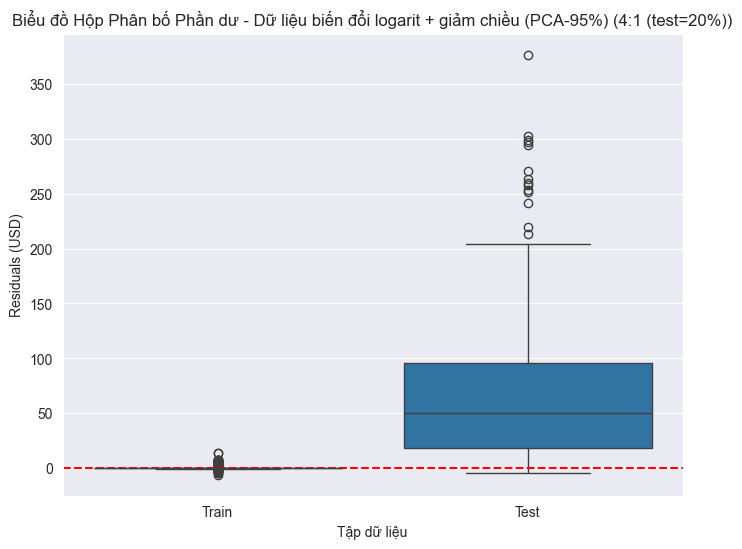

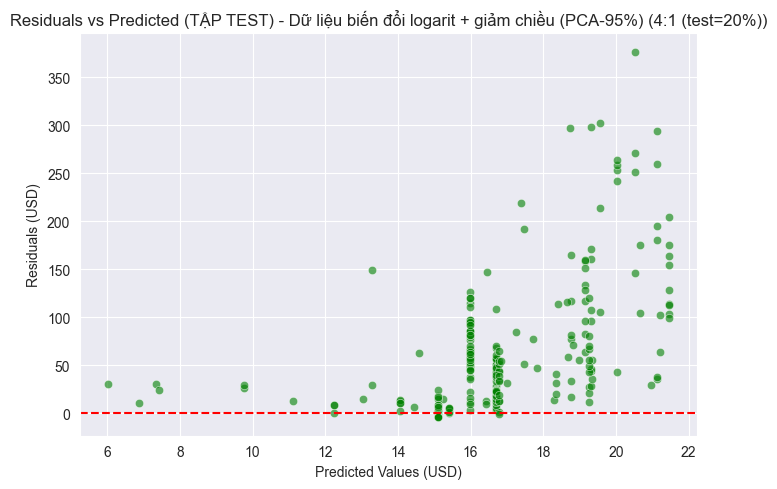


📊 Hệ số tương quan giữa phần dư (TẬP TEST) và các biến đầu vào:
   (Mô hình TỐT nếu các hệ số này GẦN 0)
Biến đầu vào  Hệ số tương quan với phần dư (Test)  |Tuyệt đối|
   Feature_1                             0.823392     0.823392
   Feature_2                             0.427936     0.427936
   Feature_5                            -0.228837     0.228837
   Feature_4                            -0.118173     0.118173
   Feature_3                            -0.094086     0.094086


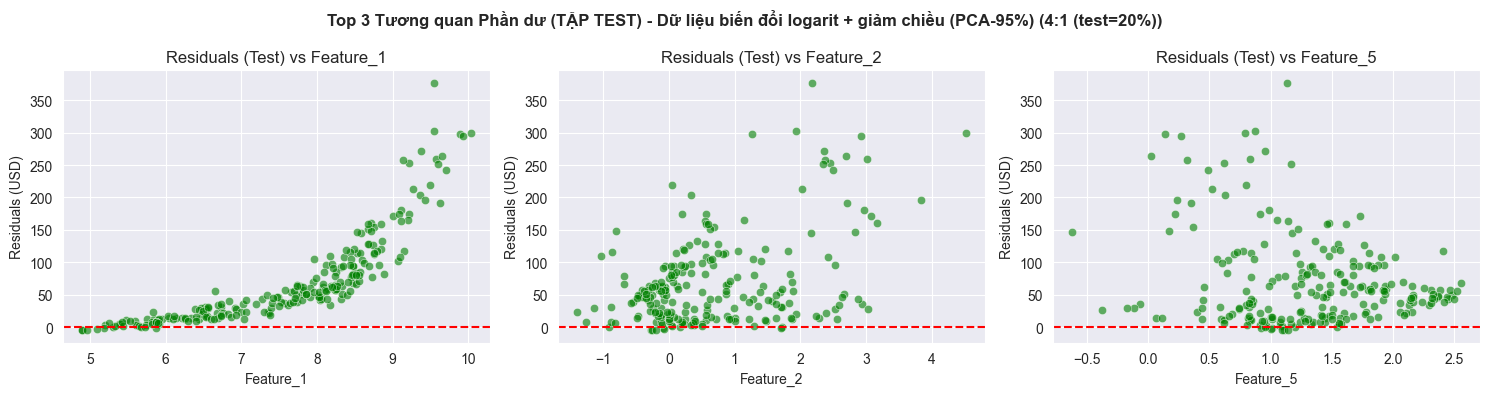

In [40]:
data_name = "Dữ liệu biến đổi logarit + giảm chiều (PCA-95%)"
split_name = "4:1 (test=20%)"
analyze_residuals(model_log_records, data_name, split_name)


#### Dựa trên các kết quả dự đoán ta thấy với chia dữ liệu train- test ngẫu nhiên thì khi dự đoán kết quả đánh giá cho ra rất tốt còn với trường hợp chia tuần tự thấy dự đoán kém có dấu hiệu rõ ràng overfit. Nguyên nhân do dữ liệu này là dữ liệu theo thời gian, mà KNN mô hình dự đoán nội suy không thể ngoại suy, tức không thể phù hợp dự đoán doanh thu trong tương lai nếu dữ liệu có xu hướng tăng/giảm theo thời gian.